# 2018-05-15 - Vers le ring, en CUDA
# CUDA RNN for MNIST

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.003

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Bidirectional recurrent neural network (many-to-one)
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        h0 = h0.cuda()
        c0 = c0.cuda()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 


Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/2], Step [100/600], Loss: 0.5080
Epoch [1/2], Step [200/600], Loss: 0.4218
Epoch [1/2], Step [300/600], Loss: 0.2023
Epoch [1/2], Step [400/600], Loss: 0.1527
Epoch [1/2], Step [500/600], Loss: 0.2056
Epoch [1/2], Step [600/600], Loss: 0.1869
Epoch [2/2], Step [100/600], Loss: 0.1641
Epoch [2/2], Step [200/600], Loss: 0.0516
Epoch [2/2], Step [300/600], Loss: 0.0756
Epoch [2/2], Step [400/600], Loss: 0.0636
Epoch [2/2], Step [500/600], Loss: 0.1260
Epoch [2/2], Step [600/600], Loss: 0.0600
Test Accuracy of the model on the 10000 test images: 97 %


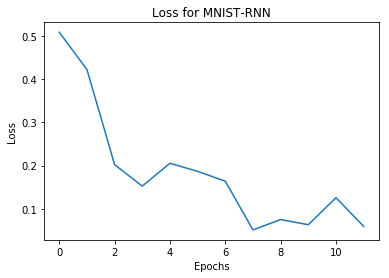

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MNIST-RNN')
plt.show()

# CUDA RNN for MotionClouds

In [6]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=False,
                                             num_workers=1)

# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 16
num_epochs = 20
learning_rate = 0.003

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        h0 = h0.cuda()
        c0 = c0.cuda()

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # LSTM output
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Start training


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Step [100/240], Loss: 2.8141
Epoch [1/20], Step [200/240], Loss: 2.4776
Epoch [2/20], Step [100/240], Loss: 2.5839
Epoch [2/20], Step [200/240], Loss: 1.9551
Epoch [3/20], Step [100/240], Loss: 1.9234
Epoch [3/20], Step [200/240], Loss: 2.0655
Epoch [4/20], Step [100/240], Loss: 2.0825
Epoch [4/20], Step [200/240], Loss: 1.5163
Epoch [5/20], Step [100/240], Loss: 3.0492
Epoch [5/20], Step [200/240], Loss: 1.1826
Epoch [6/20], Step [100/240], Loss: 1.5356
Epoch [6/20], Step [200/240], Loss: 1.9305
Epoch [7/20], Step [100/240], Loss: 1.2225
Epoch [7/20], Step [200/240], Loss: 1.1508
Epoch [8/20], Step [100/240], Loss: 0.5458
Epoch [8/20], Step [200/240], Loss: 0.5303
Epoch [9/20], Step [100/240], Loss: 0.6935
Epoch [9/20], Step [200/240], Loss: 0.9554
Epoch [10/20], Step [100/240], Loss: 0.3450
Epoch [10/20], Step [200/240], Loss: 0.2553
Epoch [11/20], Step [100/240], Loss: 0.1531
Epoch [11/20], Step [200/240], Loss: 0.3706
Epoch [12/20], Step [100/240], Loss: 0.3267
Epoch 

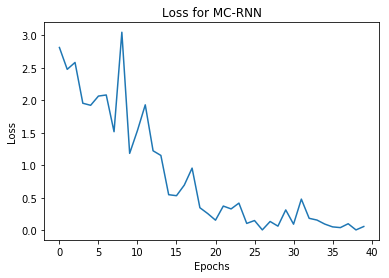

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for MC-RNN')
plt.show()